In [4]:
import requests
import pandas as pd
from dotenv import load_dotenv
import time
import os
import plotly.express as px

In [5]:
load_dotenv()
flipside_api_key = os.getenv("FLIPSIDE_API_KEY") # or can use api key directly
print(flipside_api_key)

7ef5b99e-c242-4e1d-b001-8ce9b3bbc0ba


In [6]:
def flipside_api_results(query, api_key, attempts=10, delay=30):
    """
    Creates and retrieves results for a query using Flipside's JSON-RPC API with pagination.

    Parameters:
    - query: str, the SQL query to execute.
    - api_key: str, your Flipside API key.
    - attempts: int, number of attempts to poll for query completion.
    - delay: int, delay (in seconds) between polling attempts.

    Returns:
    - pd.DataFrame: DataFrame containing the query results.
    """
    import requests
    import time
    import pandas as pd

    # Step 1: Create the query
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"
    headers = {
        "Content-Type": "application/json",
        "x-api-key": api_key
    }
    payload = {
        "jsonrpc": "2.0",
        "method": "createQueryRun",
        "params": [
            {
                "resultTTLHours": 1,
                "maxAgeMinutes": 0,
                "sql": query,
                "tags": {"source": "python-script", "env": "production"},
                "dataSource": "snowflake-default",
                "dataProvider": "flipside"
            }
        ],
        "id": 1
    }

    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()
    print(response_data)

    if 'error' in response_data:
        raise Exception(f"Error creating query: {response_data['error']['message']}")

    query_run_id = response_data.get('result', {}).get('queryRun', {}).get('id')
    if not query_run_id:
        raise KeyError(f"Query creation failed. Response: {response_data}")

    # Step 2: Poll for query completion
    for attempt in range(attempts):
        status_payload = {
            "jsonrpc": "2.0",
            "method": "getQueryRunResults",
            "params": [
                {
                    "queryRunId": query_run_id,
                    "format": "json",
                    "page": {"number": 1, "size": 10000}
                }
            ],
            "id": 1
        }
        response = requests.post(url, headers=headers, json=status_payload)
        resp_json = response.json()

        if 'result' in resp_json and 'rows' in resp_json['result']:
            # Step 3: Handle pagination
            all_rows = []
            page_number = 1

            while True:
                status_payload["params"][0]["page"]["number"] = page_number
                response = requests.post(url, headers=headers, json=status_payload)
                resp_json = response.json()

                if 'result' in resp_json and 'rows' in resp_json['result']:
                    rows = resp_json['result']['rows']
                    if not rows:
                        break  # No more rows to fetch
                    all_rows.extend(rows)
                    page_number += 1
                else:
                    break

            # Convert the rows to a DataFrame
            return pd.DataFrame(all_rows)

        if 'error' in resp_json and 'not yet completed' in resp_json['error'].get('message', '').lower():
            time.sleep(delay)  # Wait before retrying
        else:
            raise Exception(f"Unexpected error while fetching query results: {resp_json}")

    raise TimeoutError(f"Query did not complete after {attempts} attempts.")


In [7]:
query = """WITH RECURSIVE date_series AS (
  SELECT
    '2024-02-01' :: DATE AS day
  UNION
  ALL
  SELECT
    day + INTERVAL '1 day'
  FROM
    date_series
  WHERE
    day < CURRENT_DATE
),
traders AS (
  SELECT
    ORIGIN_FROM_ADDRESS,
    SUM(AMOUNT_OUT_USD) AS Volume
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    ORIGIN_FROM_ADDRESS
  HAVING
    SUM(AMOUNT_OUT_USD) > 10000000
    AND MIN(BLOCK_TIMESTAMP) >= '2024-02-01'
    AND MIN(BLOCK_TIMESTAMP) < '2024-03-01'
  ORDER BY
    SUM(AMOUNT_OUT_USD) DESC
  LIMIT
    500
),
symbols AS (
  SELECT
    DISTINCT SYMBOL,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
daily_balances AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    SYMBOL,
    CURRENT_BAL AS daily_balance,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract,
    BLOCK_TIMESTAMP,
    USER_ADDRESS
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
ranked_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS,
    ROW_NUMBER() OVER (
      PARTITION BY token_contract, day
      ORDER BY BLOCK_TIMESTAMP DESC
    ) AS rn
  FROM
    daily_balances
),
filtered_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS
  FROM
    ranked_balances
  WHERE
    rn = 1
),
filled_balances AS (
  SELECT
    ds.day,
    s.SYMBOL,
    COALESCE(fb.daily_balance, 0) AS filled_balance,
    fb.USER_ADDRESS,
    CASE
      WHEN s.SYMBOL = 'ETH' THEN LOWER('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
      ELSE fb.token_contract
    END AS token_contract
  FROM
    date_series ds
    CROSS JOIN symbols s
    LEFT JOIN filtered_balances fb ON fb.day <= ds.day
    AND fb.SYMBOL = s.SYMBOL QUALIFY ROW_NUMBER() OVER (
      PARTITION BY ds.day, s.SYMBOL
      ORDER BY fb.day DESC
    ) = 1
),
latest_prices AS (
  SELECT
    DATE_TRUNC('day', hour) AS day,
    TOKEN_ADDRESS,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY PRICE) AS price
  FROM
    ethereum.price.ez_prices_hourly
  GROUP BY
    DATE_TRUNC('day', hour), TOKEN_ADDRESS
),
balances_with_prices AS (
  SELECT
    fb.day,
    fb.SYMBOL,
    fb.filled_balance,
    USER_ADDRESS,
    lp.PRICE AS daily_price,
    fb.filled_balance * lp.PRICE AS value_in_usd
  FROM
    filled_balances fb
    LEFT JOIN latest_prices lp ON lp.TOKEN_ADDRESS = fb.token_contract
    AND lp.day = fb.day
),
aggregated_by_day AS (
  SELECT
    day,
    daily_price,
    SYMBOL,
    USER_ADDRESS,
    SUM(filled_balance) AS total_filled_balance,
    SUM(value_in_usd) AS total_value_in_usd
  FROM
    balances_with_prices
  GROUP BY
    day, SYMBOL, USER_ADDRESS, daily_price
),
aggregated_added AS (
  SELECT
    a.day,
    a.SYMBOL,
    a.daily_price,
    a.total_filled_balance,
    a.USER_ADDRESS,
    a.total_value_in_usd,
    SUM(a.total_value_in_usd) OVER (PARTITION BY a.day, a.USER_ADDRESS) AS total_usd_in_treasury
  FROM
    aggregated_by_day a
  WHERE
    a.day <= CURRENT_DATE - 1
    AND a.daily_price > 0
  ORDER BY
    a.day DESC, a.SYMBOL
),
aggregated_added2 AS (
  SELECT
    *,
    total_value_in_usd / NULLIF(total_usd_in_treasury, 0) AS composition
  FROM
    aggregated_added
  ORDER BY
    day DESC, SYMBOL, USER_ADDRESS
),
daily_returns AS (
  SELECT
    day,
    SYMBOL,
    daily_price,
    composition,
    total_filled_balance,
    total_usd_in_treasury,
    USER_ADDRESS,
    LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS prev_day_price,
    (daily_price - LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day)) / LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS daily_return
  FROM
    aggregated_added2
),
weighted_daily_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    SUM(daily_return * composition) AS weighted_daily_return
  FROM
    daily_returns
  GROUP BY
    day, USER_ADDRESS, daily_return
),
cumulative_returns AS (
  SELECT
    day,
    daily_return,
    weighted_daily_return,
    USER_ADDRESS,
    (1 + weighted_daily_return) AS daily_factor,
    EXP(SUM(LN(1 + weighted_daily_return)) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC)) - 1 AS cumulative_return
  FROM
    weighted_daily_returns
),
base_return AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    cumulative_return AS base_cumulative_return
  FROM
    cumulative_returns
  WHERE
    cumulative_return IS NOT NULL
),
normalized_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    base_cumulative_return,
    100 + (100 * (base_cumulative_return - FIRST_VALUE(base_cumulative_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC))) AS portfolio_return
  FROM
    base_return
),
return_stats AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    AVG(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS avg_daily_return,
    STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS stddev_return
  FROM
    normalized_returns
),
sharpe_ratio AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    NULLIF((portfolio_return - 0.0430 / 365) / NULLIF(STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC), 0), 0) AS daily_sharpe_ratio
  FROM
    return_stats
),
trade_counts AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT tx_hash) AS number_of_trades
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

tokens_traded AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT SYMBOL_OUT) AS unique_tokens_traded
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

final_normalized_returns AS (
  SELECT
    sr.day,
    sr.USER_ADDRESS,
    sr.base_cumulative_return,
    sr.portfolio_return,
    sr.daily_sharpe_ratio,
    CASE
      WHEN AVG(sr.portfolio_return) > 120 AND sr.daily_sharpe_ratio > 1.5 THEN 'Good Trader'
      WHEN AVG(sr.portfolio_return) BETWEEN 100 AND 120 THEN 'Average Trader'
      WHEN AVG(sr.portfolio_return) < 100 THEN 'Bad Trader'
    END AS trader_class
  FROM
    sharpe_ratio sr
  WHERE
    sr.daily_sharpe_ratio IS NOT NULL
  GROUP BY
    sr.day, sr.USER_ADDRESS, sr.base_cumulative_return, sr.portfolio_return, sr.daily_sharpe_ratio
)

SELECT
  fnr.day,
  fnr.USER_ADDRESS,
  fnr.base_cumulative_return,
  fnr.portfolio_return,
  fnr.daily_sharpe_ratio,
  fnr.trader_class,
  tc.number_of_trades,
  tt.unique_tokens_traded
FROM
  final_normalized_returns fnr
  LEFT JOIN trade_counts tc ON tc.day = fnr.day AND tc.USER_ADDRESS = fnr.USER_ADDRESS
  LEFT JOIN tokens_traded tt ON tt.day = fnr.day AND tt.USER_ADDRESS = fnr.USER_ADDRESS;
"""
"""Run the query against Flipside's query engine and await the results"""

"Run the query against Flipside's query engine and await the results"

In [8]:
df = flipside_api_results(query,flipside_api_key)

{'jsonrpc': '2.0', 'id': 1, 'result': {'queryRequest': {'id': 'cm3xd1uuz55ah5ptlp876gr8g', 'sqlStatementId': 'cm3dpozwlaolv7pnfy7feqqyj', 'userId': 'clscddgtu071com0xejwdxw78', 'tags': {'env': 'production', 'source': 'python-script'}, 'maxAgeMinutes': 0, 'resultTTLHours': 1, 'userSkipCache': True, 'triggeredQueryRun': True, 'queryRunId': 'cm3xd1uu655af5ptlujud2t34', 'createdAt': '2024-11-25T18:27:43.000Z', 'updatedAt': '2024-11-25T18:27:43.000Z'}, 'queryRun': {'id': 'cm3xd1uu655af5ptlujud2t34', 'sqlStatementId': 'cm3dpozwlaolv7pnfy7feqqyj', 'state': 'QUERY_STATE_READY', 'path': '2024/11/25/18/cm3xd1uu655af5ptlujud2t34', 'fileCount': None, 'lastFileNumber': None, 'fileNames': None, 'errorName': None, 'errorMessage': None, 'errorData': None, 'externalQueryId': None, 'dataSourceQueryId': None, 'dataSourceSessionId': None, 'startedAt': None, 'queryRunningEndedAt': None, 'queryStreamingEndedAt': None, 'endedAt': None, 'rowCount': None, 'totalSize': None, 'tags': {'env': 'production', 'sourc

In [9]:
# df.set_index('dt',inplace=True)
# df.index = pd.to_datetime(df.index)
df.drop(columns='__row_index',inplace=True)
df

,day,user_address,base_cumulative_return,portfolio_return,daily_sharpe_ratio,trader_class,number_of_trades,unique_tokens_traded
0,2024-05-10T00:00:00.000Z,0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d,-0.049529,93.716634,73.040066,Bad Trader,NaN,NaN
1,2024-09-15T00:00:00.000Z,0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c,-0.837154,14.322205,0.421474,Bad Trader,NaN,NaN
2,2024-09-29T00:00:00.000Z,0xb7dab94552302bcdff309e541d51ad203cbd7042,-0.448353,53.095413,1.806804,Bad Trader,NaN,NaN
3,2024-10-12T00:00:00.000Z,0x3e55457808fb552a7f1989d68c9daf5d3a51c027,-0.432623,60.820272,3.565700,Bad Trader,NaN,NaN
4,2024-02-27T00:00:00.000Z,0x08b505dc1603af317f8ffbf5db6359f0975d96ce,0.118287,111.838517,28.300992,Average Trader,NaN,NaN
...,...,...,...,...,...,...,...,...
18533,2024-06-03T00:00:00.000Z,0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b,13.667569,1459.881230,5.208652,Good Trader,8.0,3.0
18534,2024-07-29T00:00:00.000Z,0x8b21447e610ea904979a621e530847db1948cce9,0.290588,126.891429,14.463229,Good Trader,NaN,NaN
18535,2024-04-28T00:00:00.000Z,0x518ded2f413f275d720b199ad9d03a262e35d3b3,-0.593986,41.689432,1.639568,Bad Trader,NaN,NaN
18536,2024-05-06T00:00:00.000Z,0x725ef823a0c7ea654561e13796a9d81a9aa8398a,0.154176,101.045725,2.255748,Average Trader,NaN,NaN


In [10]:
# Convert 'day' column to datetime format and remove time component 
df['day'] = pd.to_datetime(df['day'], errors='coerce').dt.date
#Remove later
print(df.head())

          day                                user_address  \
0  2024-05-10  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1  2024-09-15  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   
2  2024-09-29  0xb7dab94552302bcdff309e541d51ad203cbd7042   
3  2024-10-12  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
4  2024-02-27  0x08b505dc1603af317f8ffbf5db6359f0975d96ce   

   base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0               -0.049529         93.716634           73.040066   
1               -0.837154         14.322205            0.421474   
2               -0.448353         53.095413            1.806804   
3               -0.432623         60.820272            3.565700   
4                0.118287        111.838517           28.300992   

     trader_class  number_of_trades  unique_tokens_traded  
0      Bad Trader               NaN                   NaN  
1      Bad Trader               NaN                   NaN  
2      Bad Trader               NaN               

In [11]:
# Define a function to detect outliers based on IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

#Find outliers for 'portfolio_return'
outliers = find_outliers_iqr(df, 'portfolio_return')
print(outliers)

              day                                user_address  \
11     2024-08-06  0x38ab25a76260b3afd48b83d21fba36ea72bf878e   
16     2024-07-22  0xe99bc90d3cb86cf095d75a020c10fbf9d4aa9a4d   
20     2024-09-15  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b   
30     2024-11-13  0xc8084f0227d4f857ec9d48c481abc040ec4a4f1f   
34     2024-09-13  0x2a45eaf79bbaff1a1d31fdd24ca67541d389ef78   
...           ...                                         ...   
18518  2024-08-16  0xc8084f0227d4f857ec9d48c481abc040ec4a4f1f   
18519  2024-06-23  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b   
18523  2024-03-24  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b   
18531  2024-03-27  0x68478b80d61e9aab4f7d63b29671b90c10799a27   
18533  2024-06-03  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b   

       base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
11               8.202377e+04      8.202456e+06            1.240026   
16               1.041085e+08      1.041085e+10            1.559130   
20    

In [12]:
# Remove outliers from 'portfolio_return' column based on IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to remove outliers from the 'portfolio_return' column
df_clean = remove_outliers_iqr(df, 'portfolio_return')

# Verify the result
print(df_clean)

              day                                user_address  \
0      2024-05-10  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1      2024-09-15  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   
2      2024-09-29  0xb7dab94552302bcdff309e541d51ad203cbd7042   
3      2024-10-12  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
4      2024-02-27  0x08b505dc1603af317f8ffbf5db6359f0975d96ce   
...           ...                                         ...   
18532  2024-10-27  0x4ef861298b42ce7d505c799eced534c5f86779ad   
18534  2024-07-29  0x8b21447e610ea904979a621e530847db1948cce9   
18535  2024-04-28  0x518ded2f413f275d720b199ad9d03a262e35d3b3   
18536  2024-05-06  0x725ef823a0c7ea654561e13796a9d81a9aa8398a   
18537  2024-05-23  0x2a45eaf79bbaff1a1d31fdd24ca67541d389ef78   

       base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0                   -0.049529         93.716634           73.040066   
1                   -0.837154         14.322205            0.421474   
2     

In [13]:
# Check for NaN values in the entire DataFrame
print(df_clean.isna().sum())

day                           0
user_address                  0
base_cumulative_return        0
portfolio_return              0
daily_sharpe_ratio            0
trader_class                  8
number_of_trades          11112
unique_tokens_traded      11112
dtype: int64


In [14]:
#drop rows in trader_class column with NaN values
df_cleann = df_clean.dropna(subset=['trader_class'])
print(df_cleann.isna().sum())

day                           0
user_address                  0
base_cumulative_return        0
portfolio_return              0
daily_sharpe_ratio            0
trader_class                  0
number_of_trades          11105
unique_tokens_traded      11105
dtype: int64


In [15]:
#Fill NaN with 0
df_cleaned = df_cleann.fillna(0)
print(df_cleaned.isna().sum())

day                       0
user_address              0
base_cumulative_return    0
portfolio_return          0
daily_sharpe_ratio        0
trader_class              0
number_of_trades          0
unique_tokens_traded      0
dtype: int64


In [16]:
df_cleaned.dtypes

day                        object
user_address               object
base_cumulative_return    float64
portfolio_return          float64
daily_sharpe_ratio        float64
trader_class               object
number_of_trades          float64
unique_tokens_traded      float64
dtype: object

In [17]:
#convert day to datetime
df_cleaned['day'] = pd.to_datetime(df_cleaned['day'])

In [18]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                      object
number_of_trades                 float64
unique_tokens_traded             float64
dtype: object

In [19]:
df_cleaned.trader_class.head()

0        Bad Trader
1        Bad Trader
2        Bad Trader
3        Bad Trader
4    Average Trader
Name: trader_class, dtype: object

In [20]:
# Convert 'trader_class' to a categorical column
df_cleaned["trader_class"] = df_cleaned["trader_class"].astype('category')
df_cleaned["trader_class"].cat.categories

Index(['Average Trader', 'Bad Trader', 'Good Trader'], dtype='object')

In [21]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                    category
number_of_trades                 float64
unique_tokens_traded             float64
dtype: object

In [22]:
# Assign unique integers to categories
df_cleaned['trader_class_numeric'] = df_cleaned['trader_class'].astype('category').cat.codes
df_cleaned['trader_class_numeric']

0        1
1        1
2        1
3        1
4        0
        ..
18532    1
18534    2
18535    1
18536    0
18537    0
Name: trader_class_numeric, Length: 15023, dtype: int8

In [23]:
df_cleaned.head()

,day,user_address,base_cumulative_return,portfolio_return,daily_sharpe_ratio,trader_class,number_of_trades,unique_tokens_traded,trader_class_numeric
0,2024-05-10,0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d,-0.049529,93.716634,73.040066,Bad Trader,0.0,0.0,1
1,2024-09-15,0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c,-0.837154,14.322205,0.421474,Bad Trader,0.0,0.0,1
2,2024-09-29,0xb7dab94552302bcdff309e541d51ad203cbd7042,-0.448353,53.095413,1.806804,Bad Trader,0.0,0.0,1
3,2024-10-12,0x3e55457808fb552a7f1989d68c9daf5d3a51c027,-0.432623,60.820272,3.565700,Bad Trader,0.0,0.0,1
4,2024-02-27,0x08b505dc1603af317f8ffbf5db6359f0975d96ce,0.118287,111.838517,28.300992,Average Trader,0.0,0.0,0


In [24]:
df_cleaned.columns

Index(['day', 'user_address', 'base_cumulative_return', 'portfolio_return',
       'daily_sharpe_ratio', 'trader_class', 'number_of_trades',
       'unique_tokens_traded', 'trader_class_numeric'],
      dtype='object')

# Correlation Coefficient Analysis

In [25]:
# Correlation Coefficient Analysis

df_cor = df_cleaned.corr(numeric_only=True)
print(df_cor['trader_class_numeric'].sort_values(ascending=False))


trader_class_numeric      1.000000
portfolio_return          0.274692
base_cumulative_return    0.241960
number_of_trades         -0.006307
unique_tokens_traded     -0.007763
daily_sharpe_ratio       -0.055788
Name: trader_class_numeric, dtype: float64


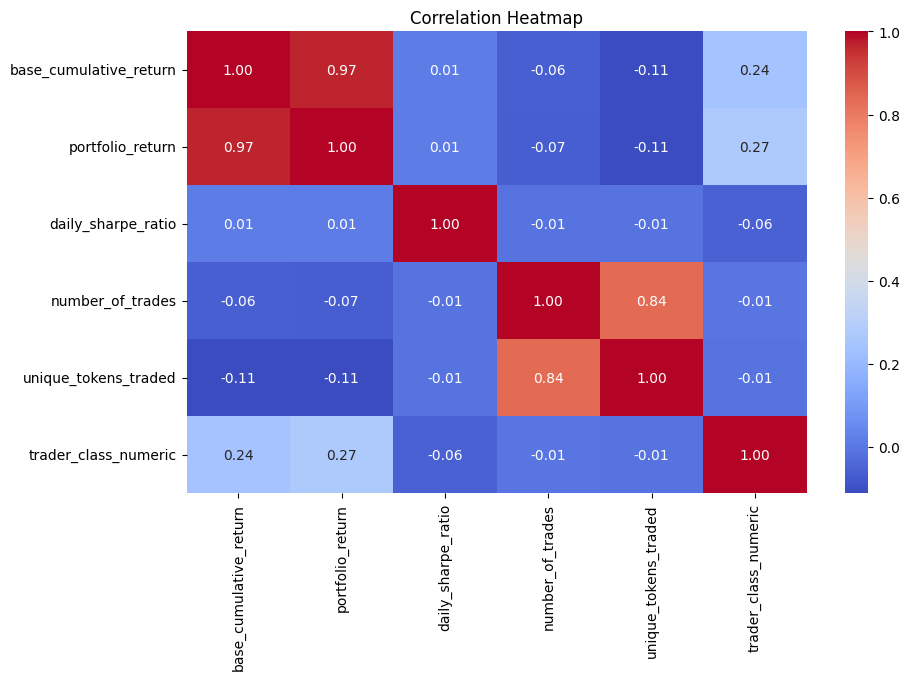

In [27]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Classifier Model

In [28]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                    category
number_of_trades                 float64
unique_tokens_traded             float64
trader_class_numeric                int8
dtype: object

In [29]:
numeric = df_cleaned.select_dtypes(include=['number'])
#numeric

In [30]:
features = ['base_cumulative_return', 'portfolio_return', 
            'daily_sharpe_ratio', 'number_of_trades', 'unique_tokens_traded']

In [31]:
target = 'trader_class_numeric'

In [32]:
df_cleaned['portfolio_return'].describe()

count    15023.000000
mean        95.410149
std         39.626239
min         -2.588934
25%         75.521814
50%         99.950774
75%        115.094243
max        234.896378
Name: portfolio_return, dtype: float64

In [33]:
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [34]:
#Data Processing
#Separating the features from the target variable.

X = df_cleaned[features]
y = df_cleaned[target]

In [35]:
#Normalize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data

In [36]:
#Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Train the Logistic Regression Model

In [37]:
#Train the logistic Regression Model
log_reg = LogisticRegression(solver='lbfgs')
# solver='lbfgs' is the default solver in newer version of sklearn
log_reg.fit(X_train, y_train)

LogisticRegression()

# Predict on the test set

In [38]:
#predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the Model

##### Confusion Matrix

In [39]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 838    3    7]
 [  36 1491    0]
 [   6    0  624]]


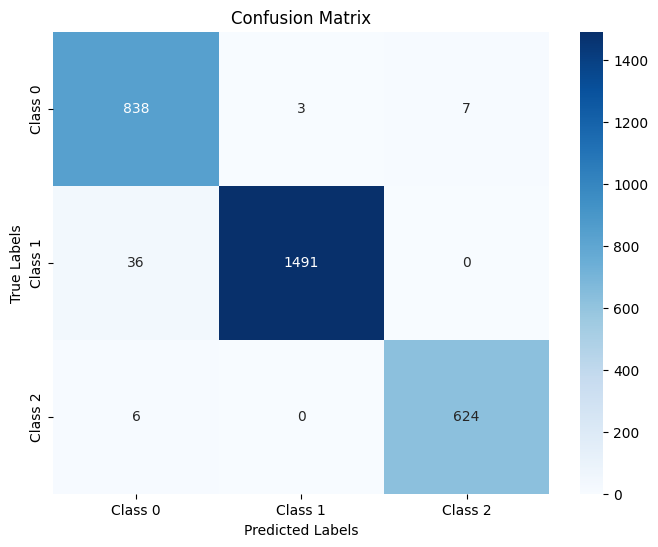

In [40]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Result: Correct predictions (True Positives for each class).

### Classification Report

In [41]:
report = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.9522727272727273, 'recall': 0.9882075471698113, 'f1-score': 0.9699074074074074, 'support': 848.0}, '1': {'precision': 0.9979919678714859, 'recall': 0.9764243614931237, 'f1-score': 0.9870903674280039, 'support': 1527.0}, '2': {'precision': 0.9889064976228209, 'recall': 0.9904761904761905, 'f1-score': 0.9896907216494846, 'support': 630.0}, 'accuracy': 0.9826955074875208, 'macro avg': {'precision': 0.9797237309223447, 'recall': 0.9850360330463751, 'f1-score': 0.9822294988282986, 'support': 3005.0}, 'weighted avg': {'precision': 0.9831853914041293, 'recall': 0.9826955074875208, 'f1-score': 0.982786564786429, 'support': 3005.0}}


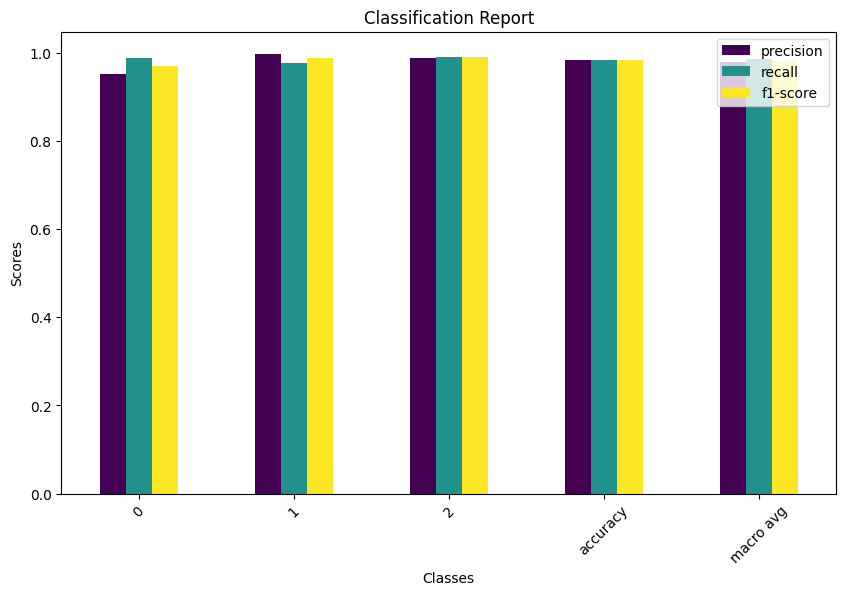

In [42]:
# Convert the dictionary to a DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and f1-score
report_df = report_df.iloc[:-1, :-1]  # Exclude support and accuracy row/column
report_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Classification Report")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.show()

#### Accuracy Score

In [43]:
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9826955074875208


In [44]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


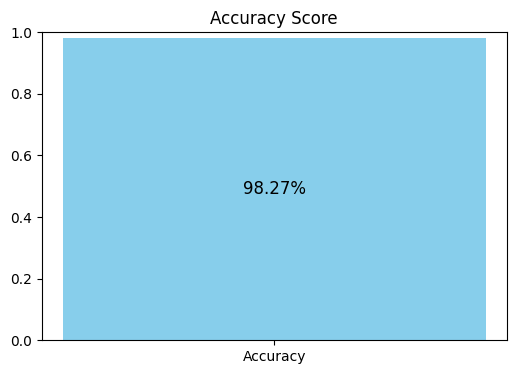

In [45]:
# Display accuracy in a plot
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy], color="skyblue")
plt.ylim(0, 1)  # Scale from 0 to 1
plt.title("Accuracy Score")
plt.text(0, accuracy / 2, f"{accuracy:.2%}", ha="center", va="center", fontsize=12)
plt.show()

#### AUROC Curve

In [46]:
# Calculate AUROC
# Get predicted probabilities for all classes
y_pred_multi = log_reg.predict_proba(X_test)

# Calculate AUROC for multi-class classification
auroc_multi = roc_auc_score(y_test, y_pred_multi, multi_class='ovr')
print(f"Area Under the ROC Curve (AUROC) for Multi-Class: {auroc_multi:.2f}")

Area Under the ROC Curve (AUROC) for Multi-Class: 1.00


# Interpret the Model

##### Logistic regression provides coefficients that indicate feature importance

In [47]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)

                  Feature  Coefficient
0  base_cumulative_return     1.937368
1        portfolio_return     1.097245
3        number_of_trades     0.423550
2      daily_sharpe_ratio     0.287509
4    unique_tokens_traded     0.221608


# Randomized Search for Hyperparameter Tuning

In [50]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution
param_distributions = {
    'C': np.logspace(-4, 4, 20),  # Exponential range for regularization
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters (Random Search):", random_search.best_params_)
print(f"Best Cross-Validation Accuracy (Random Search): {random_search.best_score_:.2f}")

# Use the best estimator for predictions
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

# Evaluate the tuned model
print("\nConfusion Matrix (Tuned Model - Random Search):")
print(confusion_matrix(y_test, y_pred_random))
print("\nClassification Report (Tuned Model - Random Search):")
print(classification_report(y_test, y_pred_random))
print(f"\nAccuracy (Tuned Model - Random Search): {accuracy_score(y_test, y_pred_random):.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

Best Parameters (Random Search): {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': np.float64(10000.0)}
Best Cross-Validation Accuracy (Random Search): 1.00

Confusion Matrix (Tuned Model - Random Search):
[[ 837    9    2]
 [   4 1523    0]
 [   2    0  628]]

Classification Report (Tuned Model - Random Search):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       848
           1       0.99      1.00      1.00      1527
           2       1.00      1.00      1.00       630

    accuracy                           0.99      3005
   macro avg       0.99      0.99      0.99      3005
weighted avg       0.99      0.99      0.99      3005


Accuracy (Tuned Model - Random Search): 0.99


/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/olaoluwatunmise/miniconda3/envs/flipml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/olaoluwatunmise/miniconda3